# Trabalho Prático 2
## Processamento de Linguagem Natural - 2018/2

### Bernardo de Almeida Abreu - 2018718155

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import re
import gensim
import nltk
import keras
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
paths = {
    'train': '../macmorpho-v3/macmorpho-train.txt',
    'test': '../macmorpho-v3/macmorpho-test.txt',
    'dev': '../macmorpho-v3/macmorpho-dev.txt',
    'word2vec': '../data/skip_s100.txt'
}

### Leitura do texto

In [3]:
def read_text(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [4]:
train_text = read_text(paths['train'])
test_text = read_text(paths['test'])
dev_text = read_text(paths['dev'])

print(train_text[0])
print(test_text[0])
print(dev_text[0])

Jersei_N atinge_V média_N de_PREP Cr$_CUR 1,4_NUM milhão_N na_PREP+ART venda_N da_PREP+ART Pinhal_NPROP em_PREP São_NPROP Paulo_NPROP ._PU

Salto_N sete_ADJ

Ainda_ADV em_PREP dezembro_N de_PREP 1990_N ,_PU foi_V editada_PCP a_ART famosa_ADJ 289_N ,_PU que_PRO-KS modificava_V a_ART sistemática_N da_PREP+ART arrecadação_N do_PREP+ART ITR_NPROP e_KC alterava_V suas_PROADJ alíquotas_N ._PU



### Separação de palavras e tags

In [24]:
def split_word_tags(text):
    word_lines = []
    tag_lines = []
    for line in text:
        words, tags = zip(*[tagged_word.split('_') for tagged_word in line.split()])
        
        word_lines.append([w.lower() if w.lower for w in words])
        tag_lines.append(list(tags))
    return word_lines, tag_lines

In [25]:
train_words, train_tags = split_word_tags(train_text)
print(train_words[0])
print(train_tags[0])

test_words, test_tags = split_word_tags(test_text)
dev_words, dev_tags = split_word_tags(dev_text)


['jersei', 'atinge', 'média', 'de', 'cr$', '1,4', 'milhão', 'na', 'venda', 'da', 'pinhal', 'em', 'são', 'paulo', '.']
['N', 'V', 'N', 'PREP', 'CUR', 'NUM', 'N', 'PREP+ART', 'N', 'PREP+ART', 'NPROP', 'PREP', 'NPROP', 'NPROP', 'PU']


In [26]:
flat_list = [item for sublist in (train_words) for item in sublist]
len(set(flat_list))

47236

## Pad the words

### Analyse sentence size distribution

In [27]:
df_train = pd.DataFrame(columns=['words', 'tags'])
df_test = pd.DataFrame(columns=['words', 'tags'])
df_dev = pd.DataFrame(columns=['words', 'tags'])

df_train['words'] = train_words
df_train['tags'] = train_tags

df_test['words'] = test_words
df_test['tags'] = test_tags

df_dev['words'] = dev_words
df_dev['tags'] = dev_tags



df_sentences = pd.concat([df_train, df_test, df_dev], axis=0)

df_sentences.shape

(49932, 2)

In [28]:
df_sentences['words'].map(len).describe()

count    49932.000000
mean        18.940779
std         12.070051
min          1.000000
25%         10.000000
50%         17.000000
75%         25.000000
max        248.000000
Name: words, dtype: float64

<IPython.core.display.Javascript object>


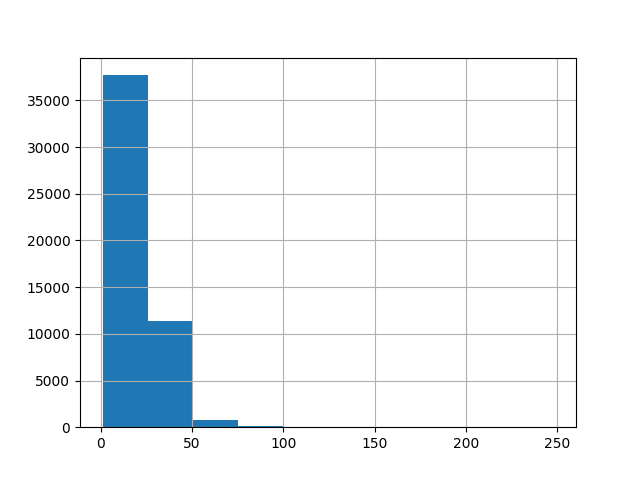

In [29]:
df_sentences['words'].map(len).hist()
plt.show()

In [30]:
max_sentence_length = int(df_sentences['words'].map(len).describe()['75%'] + 1)
max_sentence_length

26

In [31]:
def fill_sentence(sentence):
    tokens_to_fill = int(max_sentence_length - len(sentence))
    
    sentence.append('<END>')
    sentence.extend(['<PAD>']*tokens_to_fill)
    
    return sentence

In [32]:
df_sentences["words"] = df_sentences["words"].map(fill_sentence)
df_sentences["tags"] = df_sentences["tags"].map(fill_sentence)

In [33]:
df_test.head()

,words,tags
0,"[salto, sete, <END>, <PAD>, <PAD>, <PAD>, <PAD...","[N, ADJ, <END>, <PAD>, <PAD>, <PAD>, <PAD>, <P..."
1,"[o, grande, assunto, da, semana, em, nova, yor...","[ART, ADJ, N, PREP+ART, N, PREP, NPROP, NPROP,..."
2,"[número, duplo, especial, ,, é, inteirinho, de...","[N, ADJ, ADJ, PU, V, ADJ, PCP, PREP, N, PREP, ..."
3,"[a, endiabrada, editora, tina, brown, ex, da, ...","[ART, PCP, N, NPROP, NPROP, N, PREP+ART, PU, N..."
4,"[além, das, fotos, de, richard, avedon, ., <EN...","[PREP, PREP+ART, N, PREP, NPROP, NPROP, PU, <E..."


## Embedding - Word2Vec

In [34]:
all_words = train_words + test_words + dev_words
print(len(train_words))
print(len(test_words))
print(len(dev_words))
total_sentences = len(all_words)
print(total_sentences)

37948
9987
1997
49932


In [35]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(paths['word2vec'])

In [ ]:
# model.train(all_words, total_examples=total_sentences, epochs=50)

In [36]:
w2v_model.similar_by_vector('hemocentro')

[('hemopa', 0.8358802199363708),
 ('hemonúcleo', 0.8148629069328308),
 ('hemoal', 0.7524207830429077),
 ('hemorio', 0.7506005764007568),
 ('procon', 0.73494553565979),
 ('centrinho', 0.7315340042114258),
 ('hemoam', 0.7078859806060791),
 ('incor', 0.7009122371673584),
 ('detran', 0.7000018358230591),
 ('poupatempo', 0.6961973905563354)]

### Adiciona vetores extras

In [37]:
w2v_model.add(['<PAD>','<END>'], [[0.1]*100,[0.2]*100])

## Arquitetura do modelo

In [38]:
model = keras.models.Sequential()
model

### Adiciona camada de embedding

In [39]:
print(len(w2v_model.vocab))
print(max_sentence_length)
print(len(df_train))

929608
26
37948


In [40]:
model.add(keras.layers.InputLayer(input_shape=(max_sentence_length, )))

In [23]:
pretrained_weights = w2v_model.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['modelo', 'rede', 'treino', 'aprendizado']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in w2v_model.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

def word2idx(word):
    return w2v_model.vocab[word].index
def idx2word(idx):
    return w2v_model.index2word[idx]

print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(df_train), max_sentence_length], dtype=np.int32)
train_y = np.zeros([len(df_train)], dtype=np.int32)
for i, sentence in enumerate(df_train['words']):
    for t, word in enumerate(sentence[:-1]):
        print(t, word)
        train_x[i, t] = word2idx(word)
    train_y[i] = word2idx(sentence[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)

Result embedding shape: (929608, 100)
Checking similar words:
  modelo -> protótipo (0.78), conceito (0.75), padrão (0.75), propulsor (0.74), paradigma (0.73), layout (0.73), prototipo (0.72), monovolume (0.72)
  rede -> emissora (0.73), repetidora (0.72), tv (0.72), retransmissora (0.70), operadora (0.70), rádio (0.70), televisão (0.67), transmundial (0.67)
  treino -> treinamento (0.75), técnico-tático (0.68), técnico/tático (0.67), treinos (0.67), voo (0.66), vôo (0.63), rachão (0.62), trenamento (0.60)
  aprendizado -> aprimoramento (0.77), auto-conhecimento (0.74), autoconhecimento (0.71), auto-aperfeiçoamento (0.70), refinamento (0.68), amadurecimento (0.68), autocontrole (0.67), letramento (0.66)

Preparing the data for LSTM...
0 jersei
1 atinge
2 média
3 de
4 cr$
5 1,4


KeyError: '1,4'

In [ ]:
model.add(
    keras.layers.Embedding(
        input_dim=len(w2v_model.vocab),
        output_dim=300,
        input_length=max_sentence_length
    )
)

In [ ]:
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()
